In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import msprime
import math 
import matplotlib as pl
import copy
import random
import mpmath
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [18]:
## population size change with linear population contraction
def pop_size_linear(No, Nt, t, t_contraction, t_expan, t_reduce):
        n_pop_size = np.empty(len(t), dtype=float)
        
        for i in range(0,len(t)):
            if i <= int(t_expan):
                n_pop_size[i] = No
            elif i > int(t_expan) and i <= int(t_reduce):
                n_pop_size[i] = Nt
            elif i > int(t_reduce) and n_pop_size[i - 1] > No:
                n_pop_size[i] =  Nt - ((Nt - No) / t_contraction) * (i - int(t_reduce))
            elif n_pop_size[i-1] == No:
                n_pop_size[i] = No
        
        return(n_pop_size)


#function homozygosity
def homozy(pop_size, m, t):  #pop_size, mutation_rate, time
    n_homozy = np.empty(len(t), dtype=float)
    n_homozy[0] = 1    #initial homozygosity to start with
    
    for i in range(1,len(t)):
        j_t =  (1-m)**2 * ( (1/(2*pop_size[i-1])) + (1 - (1/(2*pop_size[i-1]))) * n_homozy[i-1] )
        n_homozy[i] = j_t  
    
    return(n_homozy)


## Panmictic Population size change: genetic diversity at the end of contraction

We proposed a simplified panmictic population model [Nei et al., 1975](https://onlinelibrary.wiley.com/doi/10.1111/j.1558-5646.1975.tb00807.x) which assumes similar changes in population sizes to the ones in the spatial simulation. This panmictic model allowed us to derive the expected heterozygosity ($H_e$) analytically. Forward in time, we started with a population of $N_i$ diploid individuals that were all homozygous (i.e. $H_e = 0$ or homozygosity, $F = 1$). This population immediately underwent an instantaneous population expansion to $N_{exp}$ individuals. The population then remained stable for $t_{stat}$ generations till the start of the contraction phase. During contraction, population size reduced linearly over a duration of $t_{cont}$ generations, eventually reaching $N_i$ individuals.

#### Approach 1: Using Analytical Formula as described in manuscript

In [3]:
def expected_homozygosity_single(pop,mutation_rate):
    return (1-mutation_rate)**2/(2*pop-(1-mutation_rate)**2*(2*pop-1))

In [4]:
mutation_rate=0.001
pop_initial=400
pop_expansion=12000

generation_length = [1]
results_contraction=[]


t_contractions_generations=[25, 100, 400, 600, 1000, 2000, 4000]      #np.arange(1,4002,50)
t_stationarys=[250, 2500]

for gen in generation_length:
    t_contractions=t_contractions_generations*gen
    for t_cont in t_contractions:
        for t_stat in t_stationarys:

            time_stationary=t_stat*gen
            delta_N=pop_expansion-pop_initial
            #Eq. homozygosity of expanded pop size
            homo_expansion=expected_homozygosity_single(pop_expansion,mutation_rate)

            #Start from a population at equilibrium
            homo_initial_equilibrium=expected_homozygosity_single(pop_initial,mutation_rate)
            #Start from a homozygous population
            homo_initial=1. #Either 1 if you start from a homozygous population or homo_initial_equilibrium if you start from equilibrium

            ### Compute homozygosity after stationary period
            homo_after_stationary=homo_expansion-(homo_expansion-homo_initial)*np.exp((1-mutation_rate)**2*(1-(2*pop_expansion)**(-1)-(1-mutation_rate)**(-2))*time_stationary/gen)

            # compute homozygosity after contraction
            a=(1-mutation_rate)**2/gen
            b=2*pop_expansion
            c=2*(pop_expansion-pop_initial)/t_cont

            tilde_tau_contraction=t_cont/gen

            ### Expression from WolframAlpha (Taking into account change of variables)
            homo_after_contraction=c**(-1)*b**(-a/c)*np.exp((a-gen**(-1))*t_cont)*\
            (a*b**(a/c)*np.exp(b*(gen**(-1)-a)/c)*((a-gen**(-1))*(c*t_cont-b)/c)**(a/c)*float(mpmath.gammainc(-a/c,(a-gen**(-1))*(c*t_cont-b)/c))+\
            c*homo_after_stationary*(b-c*t_cont)**(a/c)-\
            a*np.exp(b*(gen**(-1)-a)/c)*(b*(gen**-1-a)/c)**(a/c)*(b-c*t_cont)**(a/c)*float(mpmath.gammainc(-a/c,b*(gen**(-1)-a)/c)))

            results_contraction.append([gen,tilde_tau_contraction,time_stationary,1-homo_after_contraction])

results_contraction=pd.DataFrame(results_contraction,columns=['Gen_length','t_contraction','t_stationary','heterozygosity_end_contraction'])


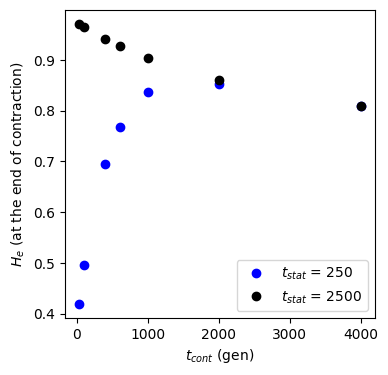

In [5]:
subset_df1 = results_contraction[results_contraction['t_stationary'] == 250]
subset_df2 = results_contraction[results_contraction['t_stationary'] == 2500]

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
# Plotting the data
plt.plot(subset_df1['t_contraction'], subset_df1['heterozygosity_end_contraction'], 
         label=r'${t}_{stat}$ = 250', marker="o", linestyle="", color="blue")
plt.plot(subset_df2['t_contraction'], subset_df2['heterozygosity_end_contraction'],  
         label=r'${t}_{stat}$ = 2500', marker="o", linestyle="", color="black")

plt.xlabel(r'${t}_{cont}$ (gen)')
plt.ylabel(r'$H_e$ (at the end of contraction)')
plt.legend(loc='lower right')
plt.show()


#### Approach 2: We also used recursive formula (Eq. 1) from [Nei et al., 1975](https://onlinelibrary.wiley.com/doi/10.1111/j.1558-5646.1975.tb00807.x) 

In [6]:
#starting condition of the population
No = 400 #starting population
Nt = 12000  #population at equilibrium

mig_rate = 0.0  #migration rate
mut_rate = 0.001 #mutation rate

no_island = 2

t = range(1, 8000)  #time 

Jo_i = 1 -  4*No*mut_rate/(4*No*mut_rate + 1) #initial equilibrium homozygosity
Jt_i = 1 - 4*Nt*mut_rate/(4*Nt*mut_rate + 1)   # final equilibrium homozygosity

t_cont_i = 1001     #time duration for reducing from Nt-No
t_expan_i = 0   #time when instantaneous expansion takes place from No-Nt
t_stationary_i = 1001
t_reduce_i = t_expan_i + t_stationary_i
p_a_i = pop_size_linear(No, Nt, t, t_cont_i, t_expan_i, t_reduce_i) #population size
h_pan = homozy(p_a_i, mut_rate, t)

In [7]:
diff_t_contraction = [25, 100, 400, 600, 1000, 2000, 4000]
#np.arange(1, 3000, 1000) 

diff_t_stationary = [250, 2500]
t_expand = 0


data_homozy = np.empty((len(diff_t_stationary),len(diff_t_contraction)), dtype=float)
data_hetero = []

for i in range(len(diff_t_stationary)):
    for j in range(len(diff_t_contraction)):
        t_reduce = diff_t_stationary[i]+ t_expand
        t_cont = diff_t_contraction[j]
        p = pop_size_linear(No, Nt, t, t_cont, t_expand, t_reduce) #population size
        h = homozy(p, mut_rate, t)
        data_homozy[i,j] = h[t_reduce+t_cont]
        #data_hetero[i,j] = 1. - h[t_reduce+t_cont]   # panmictic pop
        data_hetero.append([diff_t_stationary[i], diff_t_contraction[j], 1. - h[t_reduce+t_cont]])

data_hetero=pd.DataFrame(data_hetero, columns=['t_stat','t_cont','He_end_cont'])


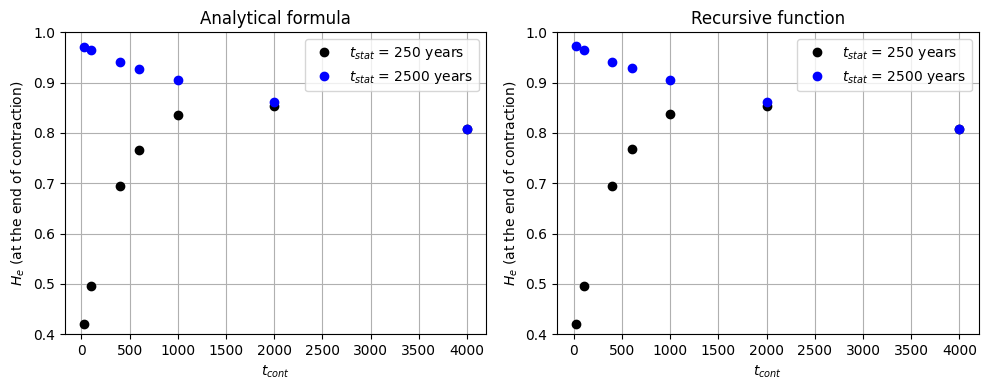

In [8]:

# Subset data
subset_df1 = results_contraction[results_contraction['t_stationary'] == 250]
subset_df2 = results_contraction[results_contraction['t_stationary'] == 2500]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# First plot
axes[0].plot(subset_df1['t_contraction'], subset_df1['heterozygosity_end_contraction'], label=r'${t}_{stat}$ = 250 years', marker="o", linestyle="", color="black")
axes[0].plot(subset_df2['t_contraction'], subset_df2['heterozygosity_end_contraction'], label=r'${t}_{stat}$ = 2500 years', marker="o", linestyle="", color="blue")
axes[0].set_xlabel(r'${t}_{cont}$')
axes[0].set_ylabel(r'$H_{e}$ (at the end of contraction)')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0.4,1)
axes[0].set_title("Analytical formula")

# Second plot
s_df1 = data_hetero[data_hetero['t_stat'] == 250]
s_df2 = data_hetero[data_hetero['t_stat'] == 2500]


axes[1].plot(s_df1['t_cont'], s_df1['He_end_cont'], label = r'${t}_{stat}$ = 250 years', marker = "o", linestyle = "", color = "black")
axes[1].plot(s_df2['t_cont'], s_df2['He_end_cont'],  label = r'${t}_{stat}$ = 2500 years', marker = "o", linestyle = "", color = "blue")
axes[1].set_xlabel(r'${t}_{cont}$')
axes[1].set_ylabel(r'$H_{e}$ (at the end of contraction)')
axes[1].set_title('Diversity vs t_cont for different t_stat values')
axes[1].grid(True)
axes[1].legend()
axes[1].set_ylim(0.4,1)
axes[1].set_title("Recursive function")

# Adjust layout
plt.tight_layout()
plt.show()


The results from analytical formulation and recursive function match.

### Validating analytical results with simulations using *msprime*

#### Infinite Alleles Model (IAM)

We begin by using the IAM model, as the analytical results were derived specifically for it.

In [9]:
#defining the function which takes particular t_stat and t_cont values and runs simulations

def GD_at_end_contraction(t_stat, t_cont):
    
    num_rep = 20
    N_initial = 400  # population size started with
    N_expanded = 12000
    mut_rate = 1e-3
    T_contraction = t_cont
    T_stationary = t_stat

    growth_t_cont = -np.log(N_initial - N_expanded/N_expanded) / (T_contraction)
    d_mutMod_site_replicates = []

    demo_expn_con = msprime.Demography()
    demo_expn_con.add_population(name = 'A', initial_size = N_initial)
    
    # Linear population expansion during the contraction phase
    for i in range(1, T_contraction + 1):
        n_pop_size = N_initial + ((N_expanded - N_initial) / T_contraction) * i
        demo_expn_con.add_population_parameters_change(time=i, initial_size=n_pop_size, population="A")

    # Constant population size during the stationary phase
    demo_expn_con.add_population_parameters_change(time=T_contraction, initial_size=N_expanded, population="A")

    # Time moves forward: no population change in stationary phase
    demo_expn_con.add_population_parameters_change(time=T_contraction + T_stationary, initial_size=2, population="A")

    ts_rep = msprime.sim_ancestry(
        samples=[msprime.SampleSet(200, population="A")],  # sample size 10 from population "A"
        demography=demo_expn_con,
        sequence_length=10,
        recombination_rate=0.5,
        num_replicates = num_rep
)

    
    for j, ts in enumerate(ts_rep):
        ts_mut = msprime.sim_mutations(ts, rate = mut_rate, model = msprime.InfiniteAlleles())
        d_mutMod_site = ts_mut.diversity(sample_sets=None, windows=None, mode='site', span_normalise=True)
        d_mutMod_site_replicates.append(d_mutMod_site)
        
    return (np.mean(d_mutMod_site_replicates), np.std(d_mutMod_site_replicates))


In [10]:
t_stat_list = [250, 2500] #list of t_stat values
t_cont_list = [25, 100, 400, 600, 1000, 2000, 4000] #list of t_cont values

data_stat_cont = pd.DataFrame(columns = ['t_stat', 't_cont', 'diversity',
                                         'sd_diversity'])

for i, j in enumerate(t_stat_list):
    print(i,j)
    for p, q in enumerate(t_cont_list):
        #print(p,q)
        t = [j, q, *GD_at_end_contraction(j, q)]
        data_stat_cont.loc[len(data_stat_cont)] = t

0 250
1 2500


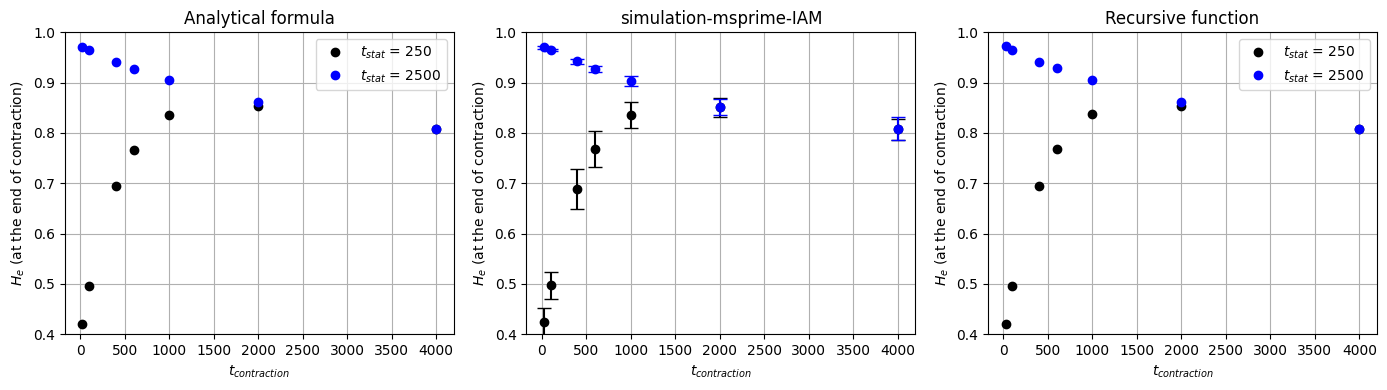

In [11]:

# linear decline
subset_df1 = results_contraction[results_contraction['t_stationary'] == 250]
subset_df2 = results_contraction[results_contraction['t_stationary'] == 2500]

#exponential decline
s_df1 = data_hetero[data_hetero['t_stat'] == 250]
s_df2 = data_hetero[data_hetero['t_stat'] == 2500]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

# First plot
axes[0].plot(subset_df1['t_contraction'], subset_df1['heterozygosity_end_contraction'], label=r'${t}_{stat}$ = 250', marker="o", linestyle="", color="black")
axes[0].plot(subset_df2['t_contraction'], subset_df2['heterozygosity_end_contraction'], label=r'${t}_{stat}$ = 2500', marker="o", linestyle="", color="blue")
axes[0].set_xlabel(r'${t}_{contraction}$')
axes[0].set_ylabel(r'$H_{e}$ (at the end of contraction)')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0.4,1)
axes[0].set_title("Analytical formula")

# Second plot
#sns.lineplot(data=data_stat_cont, x='t_cont', y='diversity', hue='t_stat', marker='o', linestyle="", errorbar=None, ax=axes[1])
colors=['black','blue']
count_color=0
for t_stat in data_stat_cont['t_stat'].unique():
    subset = data_stat_cont[data_stat_cont['t_stat'] == t_stat]
    axes[1].errorbar(subset['t_cont'], subset['diversity'], yerr=subset['sd_diversity'], fmt='o', capsize=5, label=r'$t_stat=%d$'%int(t_stat),color=colors[count_color])
    count_color+=1

axes[1].set_xlabel(r'${t}_{contraction}$')
axes[1].set_ylabel(r'$H_{e}$ (at the end of contraction)')
#axes[1].legend(title='t_stat')
axes[1].grid(True)
axes[1].set_ylim(0.4,1)
axes[1].set_title("simulation-msprime-IAM")


#third plot
axes[2].plot(s_df1['t_cont'], s_df1['He_end_cont'], label = r'${t}_{stat}$ = 250', marker = "o", linestyle = "", color = "black")
axes[2].plot(s_df2['t_cont'], s_df2['He_end_cont'],  label = r'${t}_{stat}$ = 2500', marker = "o", linestyle = "", color = "blue")
axes[2].set_xlabel(r'${t}_{contraction}$')
axes[2].set_ylabel(r'$H_{e}$ (at the end of contraction)')
axes[2].legend()
axes[2].grid(True)
axes[2].set_ylim(0.4,1)
axes[2].set_title("Recursive function")


# Adjust layout
plt.tight_layout()
plt.show()


The results from msprime are similar compared to analytical method.

### Different microsatellite mutation model: Stepwise Mutation Model (SMM), Two Phase Model (TPM)

We also tested whether the observed patterns remained consistent across different mutation models.

In [12]:
# function to work with msprime microsatellite data 
#taken from (https://tskit.dev/msprime/docs/stable/mutations.html#sec-mutations-microsats)
def copy_number_matrix(ts):
    """
    Returns the copy number matrix from the specified tree sequence
    simulated under a MicrosatMutationModel.
    """
    C = np.zeros((ts.num_sites, ts.num_samples), dtype=int)
    for var in ts.variants():
        alleles = np.array([int(allele) for allele in var.alleles])
        C[var.site.id] = alleles[var.genotypes]
    return C

### Stepwise Mutation Model

In [13]:
#defining the function which takes particular t_stat and t_cont values and runs simulations

def GD_at_end_contraction_MMM(t_stat, t_cont):
    
    num_rep = 100
    N_initial = 400  # population size started with
    N_expanded = 12000
    mut_rate = 1e-3
    T_contraction = t_cont
    T_stationary = t_stat
    H_sim = []

    growth_t_cont = -np.log(N_initial - N_expanded/N_expanded) / (T_contraction)
    
    demo_expn_con = msprime.Demography()
    demo_expn_con.add_population(name = 'A', initial_size = N_initial)
    # Linear population expansion during the contraction phase
    for i in range(1, T_contraction + 1):
        n_pop_size = N_initial + ((N_expanded - N_initial) / T_contraction) * i
        demo_expn_con.add_population_parameters_change(time=i, initial_size=n_pop_size, population="A")

    # Constant population size during the stationary phase
    demo_expn_con.add_population_parameters_change(time=T_contraction, initial_size=N_expanded, population="A")

    # Time moves forward: no population change in stationary phase
    demo_expn_con.add_population_parameters_change(time=T_contraction + T_stationary, initial_size=N_initial, population="A")

    ts_rep = msprime.sim_ancestry(
        samples=[msprime.SampleSet(200, population="A")],  # sample size 10 from population "A"
        demography=demo_expn_con,
        sequence_length=20,
        recombination_rate=0.5,
        num_replicates = num_rep
)

    
    for i, ts in enumerate(ts_rep):
        ts_mut = msprime.sim_mutations(ts, rate = mut_rate, model = msprime.SMM(lo = 1, hi = 200))
        copy_matrix = copy_number_matrix(ts_mut)
        sites = np.shape(copy_matrix)[0]
        Het_site = np.zeros(sites)

        for j in range(sites):
            site_data = copy_matrix[j]
            unique_elements, counts = np.unique(site_data, return_counts=True)  
            relative_freq_site = counts / len(site_data)
    
            H = 1 - np.sum(relative_freq_site ** 2)
            Het_site[j] = H
        H_sim.append(np.mean(Het_site))
        
    return (np.mean(H_sim), np.std(H_sim))


In [14]:
t_stat_list = [250, 2500] #list of t_stat values
t_cont_list = [25, 100, 400, 600, 1000, 2000, 4000] #list of t_cont values

data_stat_cont_SMM = pd.DataFrame(columns = ['t_stat', 't_cont', 'diversity',
                                         'sd_diversity'])

for i, j in enumerate(t_stat_list):
    print(i,j)
    for p, q in enumerate(t_cont_list):
        #print(p,q)
        t = [j, q, *GD_at_end_contraction_MMM(j, q)]
        data_stat_cont_SMM.loc[len(data_stat_cont_SMM)] = t

0 250
1 2500


### Two Phase Model

In [15]:
#defining the function which takes particular t_stat and t_cont values and runs simulations

def GD_at_end_contraction_TPM(t_stat, t_cont):
    
    num_rep = 100
    N_initial = 400  # population size started with
    N_expanded = 12000
    mut_rate = 1e-3
    T_contraction = t_cont
    T_stationary = t_stat
    H_sim = []

    growth_t_cont = -np.log(N_initial - N_expanded/N_expanded) / (T_contraction)
    
    demo_expn_con = msprime.Demography()
    demo_expn_con.add_population(name = 'A', initial_size = N_initial)
    # Linear population expansion during the contraction phase
    for i in range(1, T_contraction + 1):
        n_pop_size = N_initial + ((N_expanded - N_initial) / T_contraction) * i
        demo_expn_con.add_population_parameters_change(time=i, initial_size=n_pop_size, population="A")

    # Constant population size during the stationary phase
    demo_expn_con.add_population_parameters_change(time=T_contraction, initial_size=N_expanded, population="A")

    # Time moves forward: no population change in stationary phase
    demo_expn_con.add_population_parameters_change(time=T_contraction + T_stationary, initial_size=N_initial, population="A")

    ts_rep = msprime.sim_ancestry(
        samples=[msprime.SampleSet(200, population="A")],  # sample size 10 from population "A"
        demography=demo_expn_con,
        sequence_length=20,
        recombination_rate=0.5,
        num_replicates = num_rep
)

    
    for i, ts in enumerate(ts_rep):
        ts_mut = msprime.sim_mutations(ts, rate = mut_rate, model = msprime.TPM(p = 0.5, m = 0.5, lo = 1, hi = 200))
        copy_matrix = copy_number_matrix(ts_mut)
        sites = np.shape(copy_matrix)[0]
        Het_site = np.zeros(sites)

        for j in range(sites):
            site_data = copy_matrix[j]
            unique_elements, counts = np.unique(site_data, return_counts=True)  
            relative_freq_site = counts / len(site_data)
    
            H = 1 - np.sum(relative_freq_site ** 2)
            Het_site[j] = H
        H_sim.append(np.mean(Het_site))
        
    return (np.mean(H_sim), np.std(H_sim))


In [16]:
t_stat_list = [250, 2500] #list of t_stat values
t_cont_list = [25, 100, 400, 600, 1000, 2000, 4000] #list of t_cont values

data_stat_cont_TPM = pd.DataFrame(columns = ['t_stat', 't_cont', 'diversity',
                                         'sd_diversity'])

for i, j in enumerate(t_stat_list):
    print(i,j)
    for p, q in enumerate(t_cont_list):
        #print(p,q)
        t = [j, q, *GD_at_end_contraction_TPM(j, q)]
        data_stat_cont_TPM.loc[len(data_stat_cont_TPM)] = t

0 250
1 2500


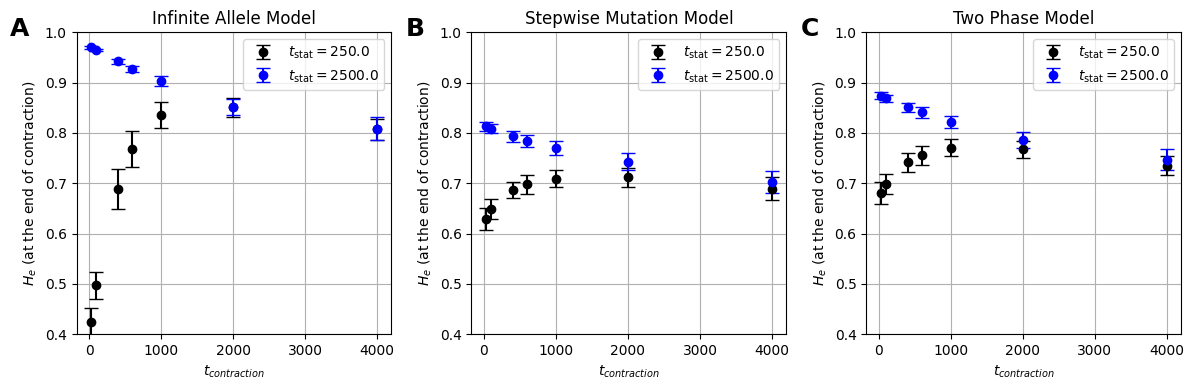

In [17]:

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))  # 1 row, 3 columns

colors=['black','blue']
count_color=0

### First subplot: Simulation - msprime
# Loop through each unique t_stat value for msprime data
for t_stat in data_stat_cont['t_stat'].unique():
    subset = data_stat_cont[data_stat_cont['t_stat'] == t_stat]
    
    # Plot the data with error bars on the first axis (axes[0])
    axes[0].errorbar(subset['t_cont'], subset['diversity'], yerr=subset['sd_diversity'], 
                     fmt='o', capsize=5, label=f'$t_{{\mathrm{{stat}}}}={t_stat}$', color=colors[count_color])
    count_color+=1

# Set labels, title, and other features for the first plot (msprime)
axes[0].set_xlabel(r'${t}_{contraction}$')
axes[0].set_ylabel(r'$H_{e}$ (at the end of contraction)')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0.4, 1)
axes[0].set_title("Infinite Allele Model")
# Add panel label A
axes[0].text(-0.15, 1.05, 'A', transform=axes[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')




### Second subplot: Simulation - SMM
# Loop through each unique t_stat value for SMM data
count_color=0
for t_stat in data_stat_cont_SMM['t_stat'].unique():
    subset = data_stat_cont_SMM[data_stat_cont_SMM['t_stat'] == t_stat]
    
    # Plot the data with error bars on the second axis (axes[1])
    axes[1].errorbar(subset['t_cont'], subset['diversity'], yerr=subset['sd_diversity'], 
                     fmt='o', capsize=5, label=f'$t_{{\mathrm{{stat}}}}={t_stat}$', color=colors[count_color])
    count_color+=1

# Set labels, title, and other features for the second plot (SMM)
axes[1].set_xlabel(r'${t}_{contraction}$')
axes[1].set_ylabel(r'$H_{e}$ (at the end of contraction)')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(0.4, 1)
axes[1].set_title("Stepwise Mutation Model")
# Add panel label B
axes[1].text(-0.15, 1.05, 'B', transform=axes[1].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')




### Third subplot: Simulation - TPM
# Loop through each unique t_stat value for TPM data
count_color=0
for t_stat in data_stat_cont_TPM['t_stat'].unique():
    subset = data_stat_cont_TPM[data_stat_cont_TPM['t_stat'] == t_stat]
    
    # Plot the data with error bars on the third axis (axes[2])
    axes[2].errorbar(subset['t_cont'], subset['diversity'], yerr=subset['sd_diversity'], 
                     fmt='o', capsize=5, label=f'$t_{{\mathrm{{stat}}}}={t_stat}$', color=colors[count_color])
    count_color+=1

# Set labels, title, and other features for the third plot (TPM)
axes[2].set_xlabel(r'${t}_{contraction}$')
axes[2].set_ylabel(r'$H_e$ (at the end of contraction)')
axes[2].legend()
axes[2].grid(True)
axes[2].set_ylim(0.4, 1)
axes[2].set_title("Two Phase Model")
# Add panel label C
axes[2].text(-0.15, 1.05, 'C', transform=axes[2].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')




# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a PDF before displaying it
plt.savefig('diff_mut_models.pdf', format='pdf', bbox_inches='tight')

# Show the combined plot
plt.show()

# Creating Figure 5 (from paper)

## Panel B3

In [18]:
#INCREASING Hexp in contraction phase

#starting condition of the population
No = 4000 #starting population
Nt = 12000  #population at equilibrium
u = 0.001  #mutation rate

t = range(1, 3000)  #time 

Jo_i = 1 -  4*No*u/(4*No*u + 1) #initial equilibrium homozygosity
Jt_i = 1 - 4*Nt*u/(4*Nt*u + 1)   # final equilibrium homozygosity

t_cont_i = 800     #time duration for reducing from Nt-No
t_expan_i = 0   #time when instantaneous expansion takes place from No-Nt
t_stationary_i = 1000
#t_reduce = 4000  #time at which contraction takes place
t_reduce_i = t_expan_i + t_stationary_i
p_a_i = pop_size_linear(No, Nt, t, t_cont_i, t_expan_i, t_reduce_i) #population size
h_a_i = homozy(p_a_i, u, t)

## Panel B1

In [19]:
#DECREASING Hexp in contraction phase

#starting condition of the population
No = 50 #starting population
Nt = 250  #population at equilibrium
u = 0.001  #mutation rate

t = range(1, 3000)  #time 

Jo_d = 1 -  4*No*u/(4*No*u + 1) #initial equilibrium homozygosity
Jt_d = 1 - 4*Nt*u/(4*Nt*u + 1)   # final equilibrium homozygosity

t_cont_d = 800     #time duration for reducing from Nt-No
t_expan_d = 0   #time when instantaneous expansion takes place from No-Nt
t_stationary_d = 1000
#t_reduce = 4000  #time at which contraction takes place
t_reduce_d = t_expan_d + t_stationary_d
p_a_d = pop_size_linear(No, Nt, t, t_cont_d, t_expan_d, t_reduce_d) #population size
h_a_d = homozy(p_a_d, u,t)

## Panel B2

In [20]:
#INC + DEC Hexp in contraction phase

#starting condition of the population
No = 100 #starting population
Nt = 10000  #population at equilibrium

u = 0.001  #mutation rate

t = range(1, 3000)  #time 

Jo_i_d = 1 -  4*No*u/(4*No*u + 1) #initial equilibrium homozygosity
Jt_i_d = 1 - 4*Nt*u/(4*Nt*u + 1)   # final equilibrium homozygosity

t_cont_i_d = 800     #time duration for reducing from Nt-No
t_expan_i_d = 0   #time when instantaneous expansion takes place from No-Nt
t_stationary_i_d = 1000
#t_reduce = 4000  #time at which contraction takes place
t_reduce_i_d = t_expan_i_d + t_stationary_i_d
p_a_i_d = pop_size_linear(No, Nt, t, t_cont_i_d, t_expan_i_d, t_reduce_i_d) #population size
h_a_i_d = homozy(p_a_i_d, u, t)

## Getting data points for Panel E

In [21]:
empirical_data_species=pd.read_csv('G_0.5_5_2_18x13_K100_m2_40ind_SW.csv') #### You have to change this to the github folder

empirical_data_species_contraction_times=empirical_data_species['contraction_time'].values[::4]
empirical_data_species=empirical_data_species[empirical_data_species['contraction_time'].isin(empirical_data_species_contraction_times)]


## Generating data points for Panel C, D

In [22]:
mutation_rate=0.001
pop_initial=400
pop_expansion=12000

generation_length = [1]
results_contraction_100=[]

seq1 = np.arange(1, 101, 50)
seq2 = np.arange(100, 4001, 50)
combined_seq = np.concatenate((seq1, seq2))

t_contractions_generations=combined_seq      
t_stationarys=combined_seq

for gen in generation_length:
    t_contractions=t_contractions_generations*gen
    for t_cont in t_contractions:
        for t_stat in t_stationarys:

            time_stationary=t_stat*gen
            delta_N=pop_expansion-pop_initial
            #Eq. homozygosity of expanded pop size
            homo_expansion=expected_homozygosity_single(pop_expansion,mutation_rate)

            #Start from a population at equilibrium
            homo_initial_equilibrium=expected_homozygosity_single(pop_initial,mutation_rate)
            #Start from a homozygous population
            homo_initial=1. #Either 1 if you start from a homozygous population or homo_initial_equilibrium if you start from equilibrium

            homo_after_equilibrium=homo_expansion-(homo_expansion-homo_initial)*np.exp((1-mutation_rate)**2*(1-(2*pop_expansion)**(-1)-(1-mutation_rate)**(-2))*time_stationary/gen)

            # compute homozygosity after contraction
            a=(1-mutation_rate)**2/gen
            b=2*pop_expansion
            c=2*(pop_expansion-pop_initial)/t_cont

            tilde_tau_contraction=t_cont/gen

            ### Expression from WolframAlpha (Taking into account change of variables)
            homo_after_contraction=c**(-1)*b**(-a/c)*np.exp((a-gen**(-1))*t_cont)*\
            (a*b**(a/c)*np.exp(b*(gen**(-1)-a)/c)*((a-gen**(-1))*(c*t_cont-b)/c)**(a/c)*float(mpmath.gammainc(-a/c,(a-gen**(-1))*(c*t_cont-b)/c))+\
            c*homo_after_equilibrium*(b-c*t_cont)**(a/c)-\
            a*np.exp(b*(gen**(-1)-a)/c)*(b*(gen**-1-a)/c)**(a/c)*(b-c*t_cont)**(a/c)*float(mpmath.gammainc(-a/c,b*(gen**(-1)-a)/c)))

            ### Simplified expression (Undoing change of variables)
            homo_after_contraction_new=homo_after_equilibrium*np.exp(-tilde_tau_contraction*(1-(1-mutation_rate)**2))*(pop_initial/pop_expansion)**((1-mutation_rate)**2*tilde_tau_contraction/(2*delta_N))\
            +np.exp((1-(1-mutation_rate)**2)*pop_initial/delta_N*tilde_tau_contraction)*(1-mutation_rate)**2/(2*delta_N)*tilde_tau_contraction*((1-(1-mutation_rate)**2)*pop_initial/delta_N*tilde_tau_contraction)**((1-mutation_rate)**2*tilde_tau_contraction/(2*delta_N))\
            *(float(mpmath.gammainc(-(1-mutation_rate)**2*tilde_tau_contraction/(2*delta_N),(1-(1-mutation_rate)**2)*pop_initial/delta_N*tilde_tau_contraction))-\
                    float(mpmath.gammainc(-(1-mutation_rate)**2*tilde_tau_contraction/(2*delta_N),(1-(1-mutation_rate)**2)*pop_expansion/delta_N*tilde_tau_contraction)))

            results_contraction_100.append([gen,tilde_tau_contraction,time_stationary,1-homo_after_contraction,1-homo_after_contraction_new])

results_contraction_100=pd.DataFrame(results_contraction_100,columns=['Gen_length','t_contraction','t_stationary','heterozygosity_end_contraction','heterozygosity_end_contraction_new'])


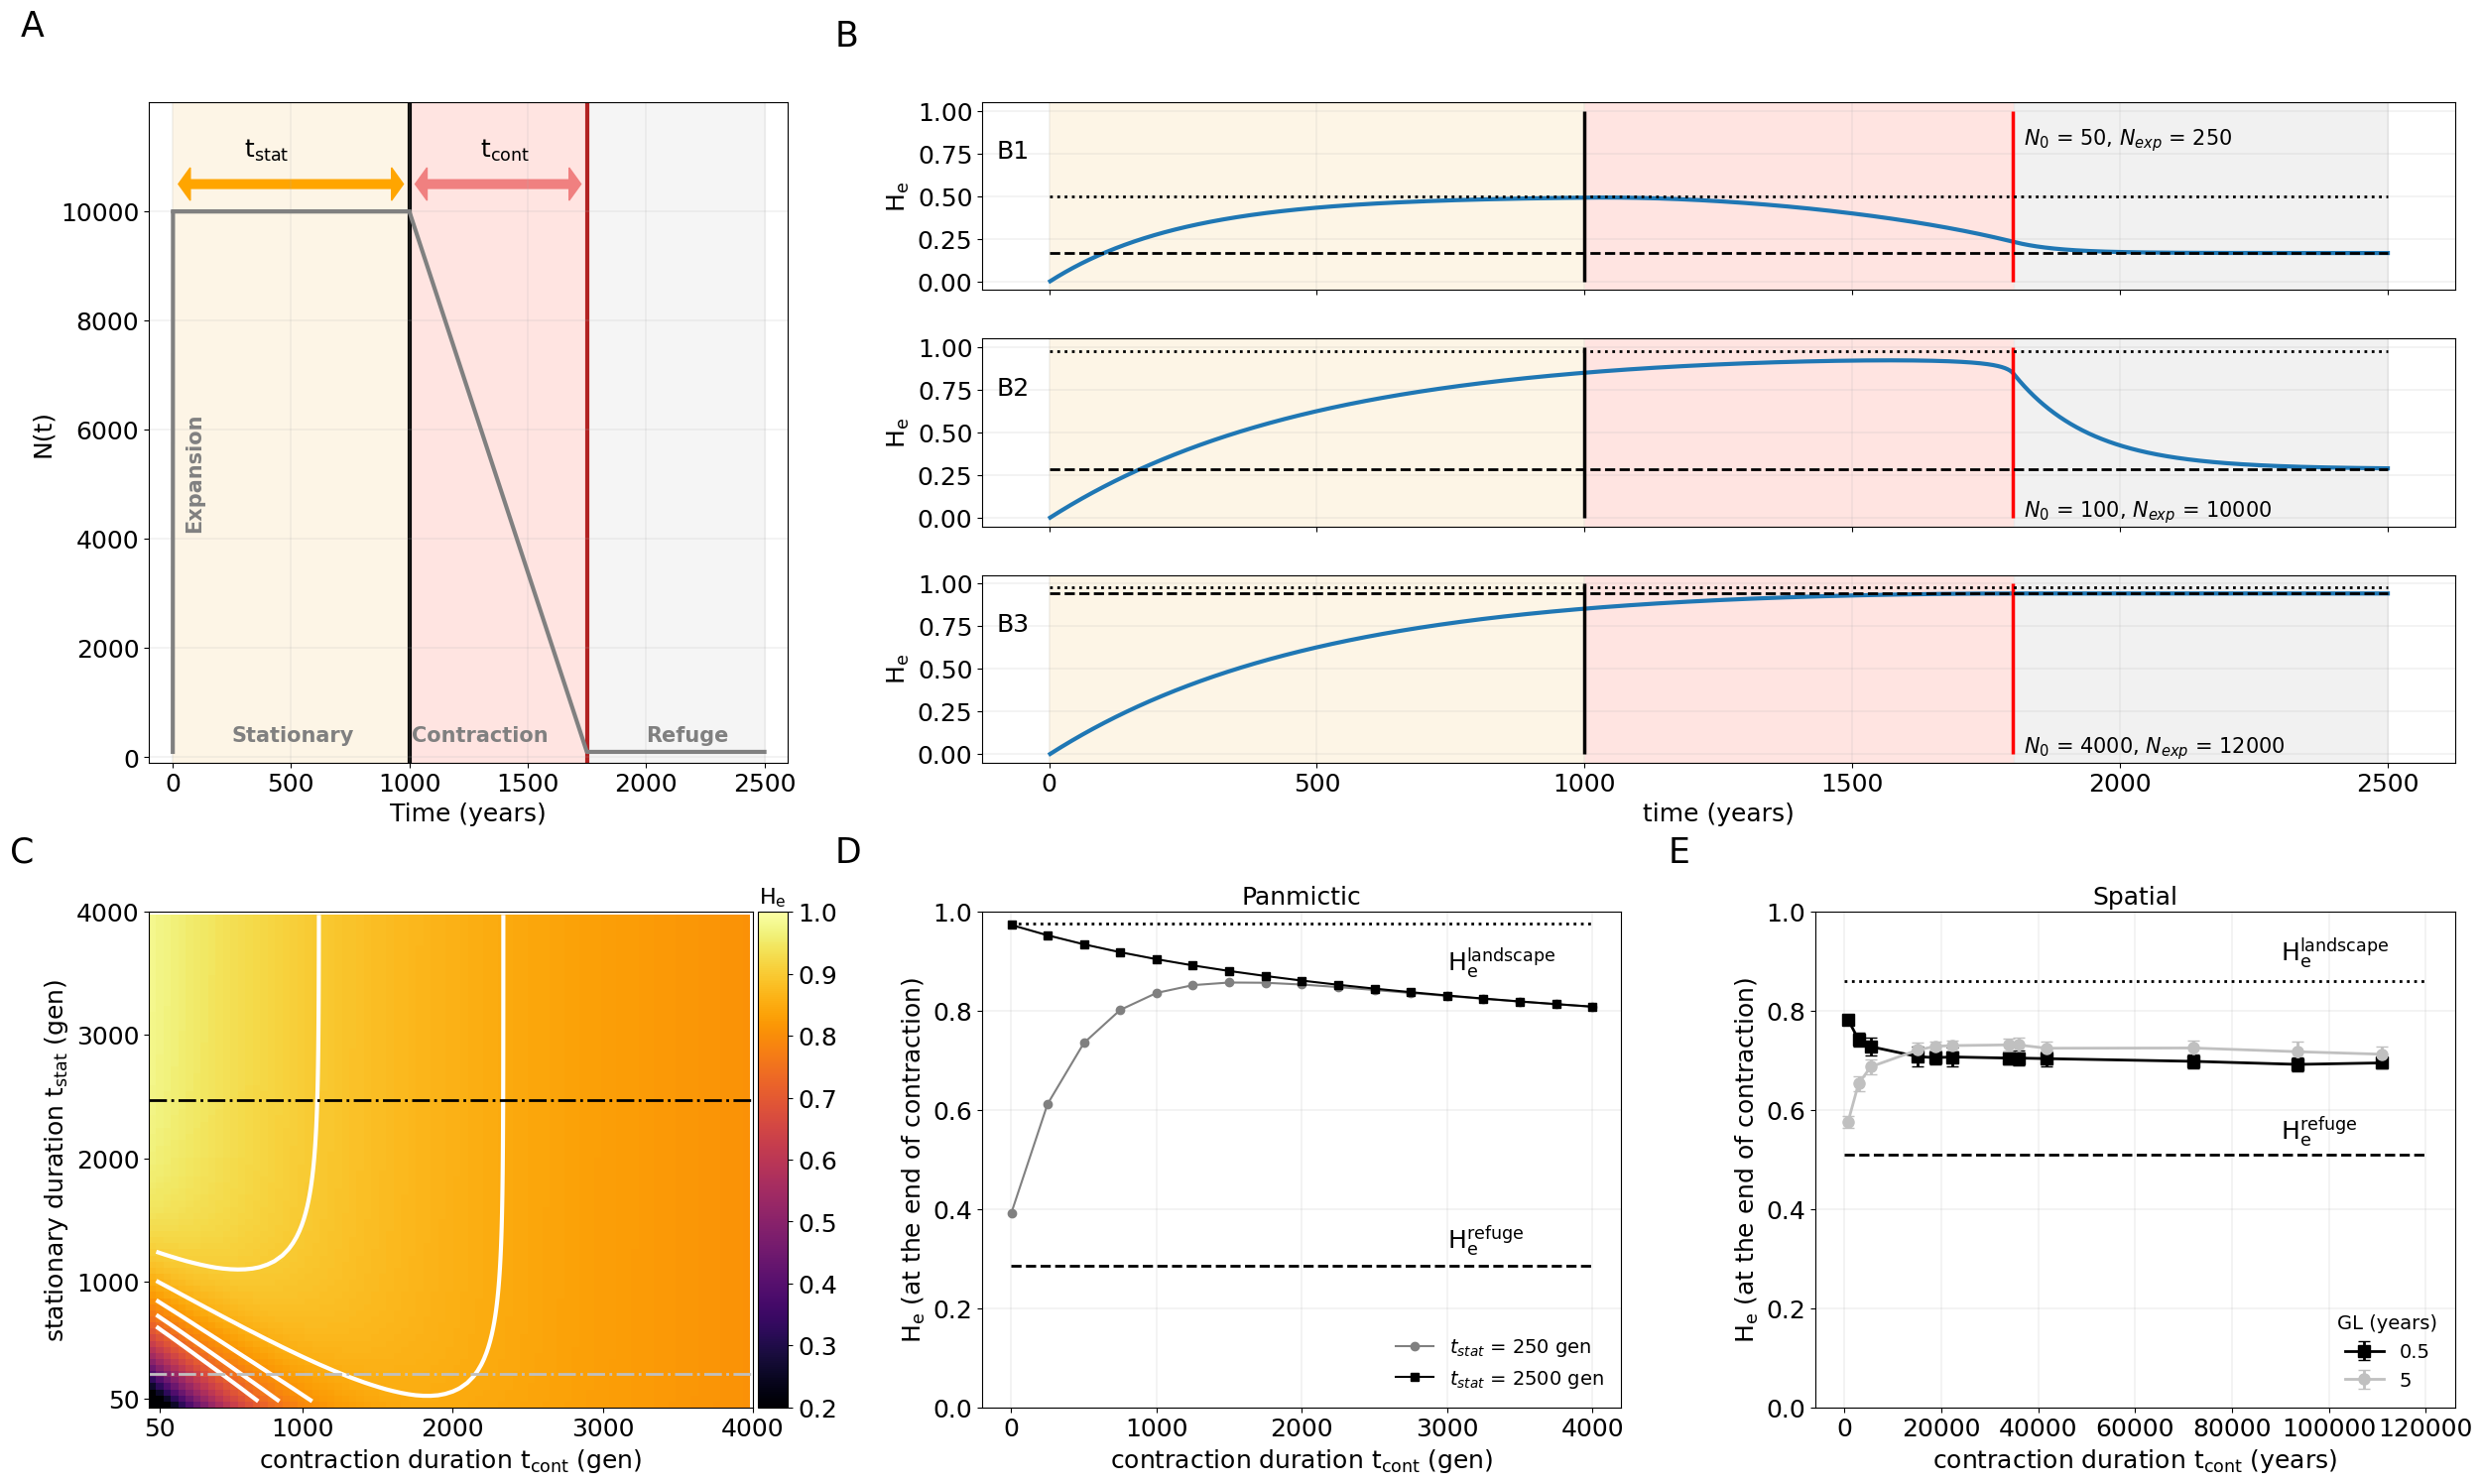

In [23]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(25,15))
gs = GridSpec(2, 3, figure=fig,height_ratios=[1,.75])
panelA= fig.add_subplot(gs[0, 0])

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec = gs[0,1:])
panelB1=fig.add_subplot(gs1[0])
panelB2=fig.add_subplot(gs1[1])
panelB3=fig.add_subplot(gs1[2])

panelC=fig.add_subplot(gs[1,0])
panelD=fig.add_subplot(gs[1,1])
panelE=fig.add_subplot(gs[1,2])


################# Panel A #########################

popvalues=[]
time1=[]
time2=[]
popvalues2=[]
popreduced=100
popextended=10000
count=0

for i in range(0,1):
    popvalues.append(popreduced)
    count+=1
    time1.append(count)
for i in range(1,1000):
    popvalues2.append(popextended)
    #count+=1
    popvalues.append(popextended)
    count+=1
    time1.append(count)
    time2.append(count)

for i in range(1,751):
    popvalues2.append(popextended-(popextended-popreduced)*i/750)
    count+=1
    time2.append(count)

for i in range(1,751):
    popvalues2.append(popreduced)
    count+=1
    time2.append(count)
 
ax=panelA

ax.plot(time1,popvalues,color='grey',lw=3)
ax.plot(time2,popvalues2,color='grey',lw=3)

ax.text(50,4200,'Expansion',rotation=90,fontsize=15,color='grey',weight='bold')
ax.text(250,300,'Stationary',rotation=0,fontsize=15,color='grey',weight='bold')
ax.text(1010,300,'Contraction',rotation=0,fontsize=15,color='grey',weight='bold')
ax.text(2000,300,'Refuge',rotation=0,fontsize=15,color='grey',weight='bold')
ax.tick_params(which='major',axis='both',labelsize=18)
ax.axvspan(0,1000,color='oldlace',alpha=1,zorder=0)
ax.axvspan(1001,1750,color='mistyrose',alpha=1,zorder=0)
ax.axvspan(1751,2500,color='whitesmoke',alpha=1,zorder=0)

ax.arrow(75,10500,850,0,shape='full',width=150,head_width=600,head_length=50,length_includes_head=False,color='orange')
ax.arrow(925,10500,-850,0,shape='full',width=150,head_width=600,head_length=50,length_includes_head=False,color='orange')

ax.arrow(1675,10500,-600,0,shape='full',width=150,head_width=600,head_length=50,length_includes_head=False,color='lightcoral')
ax.arrow(1075,10500,600,0,shape='full',width=150,head_width=600,head_length=50,length_includes_head=False,color='lightcoral')

ax.text(300,11000,r'$\mathrm{t}_{\mathrm{stat}}$',color='black',fontsize=18,weight='bold')
ax.text(1300,11000,r'$\mathrm{t}_{\mathrm{cont}}$',color='black',fontsize=18,weight='bold')

ax.vlines(1000,-200,13000,color='black',zorder=1,lw=3)
ax.vlines(1750,-200,13000,color='firebrick',zorder=1,lw=3)

ax.set_yticks(np.arange(0,10001,2000))

ax.set_ylabel(r'N(t)',fontsize=18)
ax.set_xlabel('Time (years)',fontsize=18)

ax.set_ylim(-100,12000)
ax.set_xlim(-100,2600)
ax.grid(linewidth=0.2)

ax.text(-0.20,1.10,'A',transform=ax.transAxes,fontsize=25)
ax.set_rasterized(True)
################# Panel A #########################

################ Panel B1 ########################
yticks = np.arange(0, 1.01, step=0.25)
plt=panelB1

plt.set_ylabel(r'H$_\mathrm{e}$', fontsize=18)
plt.axvspan(0,1000,color='oldlace',alpha=1,zorder=0)
plt.axvspan(1001,1800,color='mistyrose',alpha=1,zorder=0)
plt.axvspan(1801,2500,color='lightgrey',alpha=0.3,zorder=0)
plt.tick_params(labelsize=18)
plt.tick_params(axis='x',labelbottom=False)
plt.set_yticks(yticks)
p_d = plt.plot(t[1:2500],1 - h_a_d[1:2500] , linewidth=3.0)
plt.grid(linewidth=0.2)
plt.annotate("$N_0$ = 50, $N_{exp}$ = 250", xy = (1820,0.8), fontsize = 15)
plt.vlines(x = int(t_reduce_d)+int(t_cont_d), ymin = 0, ymax = 1,
           colors = 'red',
           label = 'vline_multiple - full height', linewidth=2.5)
plt.vlines(x = int(t_reduce_d), ymin = 0, ymax = 1,
           colors = 'black', linestyles = "-",
           label = 'vline_multiple - full height', linewidth=2.5)
plt.hlines(y = 1 - Jo_d, xmin = 0, xmax = 2500,
           colors = 'black', linestyles = "dashed",
           label = 'initial equilibrium Homozy', linewidth=2)
plt.hlines(y = 1 - Jt_d, xmin = 0, xmax = 2500,
           colors = 'black', linestyles = "dotted",
           label = 'initial equilibrium Homozy', linewidth=2)


plt.text(-0.10,1.30,'B',transform=plt.transAxes,fontsize=25)
plt.text(0.01,0.70,'B1',transform=plt.transAxes,fontsize=18)
plt.set_rasterized(True)
############### Panel B1 ########################################



############## Panel B2 #######################################

plt=panelB2

plt.set_ylabel(r'H$_\mathrm{e}$', fontsize=18)
plt.axvspan(0,1000,color='oldlace',alpha=1,zorder=0)
plt.axvspan(1001,1800,color='mistyrose',alpha=1,zorder=0)
plt.axvspan(1801,2500,color='lightgrey',alpha=0.3,zorder=0)
plt.tick_params(labelsize=18)
plt.tick_params(axis='x',labelbottom=False)
p_i_d = plt.plot(t[1:2500],1 - h_a_i_d[1:2500], linewidth=3.0)
plt.grid(linewidth=0.2)
plt.set_yticks(yticks)
plt.annotate("$N_0$ = 100, $N_{exp}$ = 10000", xy = (1820,0.01), fontsize = 15)
plt.vlines(x = int(t_reduce_i_d)+int(t_cont_i_d), ymin = 0, ymax = 1,
           colors = 'red',
           label = 'vline_multiple - full height', linewidth=2.5)
plt.vlines(x = int(t_reduce_i_d), ymin = 0, ymax = 1,
           colors = 'black', linestyles = "-",
           label = 'vline_multiple - full height', linewidth=2.5)
plt.hlines(y = 1 - Jo_i_d, xmin = 0, xmax = 2500,
           colors = 'black', linestyles = "dashed",
           label = 'initial equilibrium Homozy', linewidth=2)
plt.hlines(y = 1 - Jt_i_d, xmin = 0, xmax = 2500,
           colors = 'black', linestyles = "dotted",
           label = 'initial equilibrium Homozy', linewidth=2)

plt.text(0.01,0.70,'B2',transform=plt.transAxes,fontsize=18)
plt.set_rasterized(True)
################# Panel B2 #################################

################ Panel B3 ##################################

plt=panelB3

plt.axvspan(0,1000,color='oldlace',alpha=1,zorder=0)
plt.set_ylabel(r'H$_\mathrm{e}$', fontsize=18)
plt.axvspan(0,1000,color='oldlace',alpha=1,zorder=0)
plt.axvspan(1001,1800,color='mistyrose',alpha=1,zorder=0)
plt.axvspan(1801,2500,color='lightgrey',alpha=0.3,zorder=0)
plt.set_xlabel('time (years)', fontsize=18)
plt.tick_params(which='major',axis='both',labelsize=18)
plt.set_yticks(yticks)
p_i = plt.plot(t[1:2500],1 - h_a_i[1:2500], linewidth=3.0)
plt.grid(linewidth=0.2)
plt.annotate("$N_0$ = 4000, $N_{exp}$ = 12000", xy = (1820,0.01), fontsize = 15)
plt.vlines(x = int(t_reduce_i)+int(t_cont_i), ymin = 0, ymax = 1,
           colors = 'red',
           label = 'vline_multiple - full height', linewidth=2.5)
plt.vlines(x = int(t_reduce_i), ymin = 0, ymax = 1,
           colors = 'black', linestyles = "-",
           label = 'vline_multiple - full height', linewidth=2.5)
plt.hlines(y = 1 - Jo_i, xmin = 0, xmax = 2500,
           colors = 'black', linestyles = "dashed",
           label = 'initial equilibrium Homozy', linewidth=2)
plt.hlines(y = 1 - Jt_i, xmin = 0, xmax = 2500,
           colors = 'black', linestyles = "dotted",
           label = 'initial equilibrium Homozy', linewidth=2)

plt.text(0.01,0.70,'B3',transform=plt.transAxes,fontsize=18)
plt.set_rasterized(True)


############# Panel C #######################################################

ax=panelC

#data_heatmap = results_contraction_100
data_heatmap=results_contraction_100
piv = pd.pivot_table(results_contraction_100, values="heterozygosity_end_contraction", index=["t_stationary"], columns=["t_contraction"])

heatmap=ax.imshow(piv,cmap='inferno',origin='lower',aspect='auto',vmin=0.2,vmax=1)

CS=ax.contour(piv,levels=[.70, 0.75, 0.80, 0.85, 0.90],origin='lower',colors='white',linewidths=3)



ticks_labels=[50,1000,2000,3000,4000]
ticks=[len(piv)*(x-piv.index.min())/(piv.index.max()-piv.index.min()) for x in ticks_labels]

ticks_xaxis=ticks

ticks_yaxis=ticks

ax.set_xticks(ticks_xaxis)
ax.set_yticks(ticks_yaxis)

ticks_xaxislabels=ticks_labels

ticks_yaxislabels=ticks_labels

ax.set_xticklabels(ticks_xaxislabels)
ax.set_yticklabels(ticks_yaxislabels)

ax.set_xlabel(r'contraction duration t$_{\mathrm{cont}}$ (gen)',fontsize=18)

ax.set_ylabel(r'stationary duration t$_{\mathrm{stat}}$ (gen)',fontsize=18)


# Horizontal lines for specific t_stat values
ax.axhline(50, lw=2, c='black', linestyle='-.', label=r'$t_{\mathrm{stat}} = 2500$ gen')
ax.axhline(5, lw=2, c='silver', linestyle='-.', label=r'$t_{\mathrm{stat}} = 250$ gen')


ax.tick_params(which='major',axis='both',labelsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(heatmap,cax=cax)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_title(r'$\mathrm{H}_{\mathrm{e}}$',fontsize=16)

#ax.legend(fontsize=12,loc=[0.55,0.2])
ax.text(-0.23,1.10,'C',transform=ax.transAxes,fontsize=25)
ax.set_rasterized(True)
############## Panel C ######################################################


################ Panel D ####################################################
subset_df1 = data_heatmap[data_heatmap['t_stationary'] == 250]
subset_df2 = data_heatmap[data_heatmap['t_stationary'] == 2500]

ax=panelD

tau_contraction_values=subset_df1['t_contraction'].values[::5]

subset_df1 = subset_df1[subset_df1['t_contraction'].isin(tau_contraction_values)]
subset_df2 = subset_df2[subset_df2['t_contraction'].isin(tau_contraction_values)]
ax.plot(subset_df1['t_contraction'], subset_df1['heterozygosity_end_contraction'], label = r'${t}_{stat}$ = 250 gen', marker='o', color = "grey")

ax.plot(subset_df2['t_contraction'], subset_df2['heterozygosity_end_contraction'],  label = r'${t}_{stat}$ = 2500 gen', marker='s', color = "black")

ax.hlines(y = 1 - Jt_i_d,xmin = 0, xmax = 4000, colors = 'black', linestyles = "dotted", lw= 2)
ax.hlines(y = 1 - Jo_i_d, xmin = 0, xmax = 4000, colors = 'black', linestyles = "dashed", lw = 2)

ax.text(3000,0.32,r'$\mathrm{H}^{\mathrm{refuge}}_{\mathrm{e}}$',fontsize=18)
ax.text(3000,0.88,r'$\mathrm{H}^{\mathrm{landscape}}_{\mathrm{e}}$',fontsize=18)

ax.tick_params(which='major',axis='both',labelsize=18)
ax.set_xlabel(r'contraction duration t$_\mathrm{cont}$ (gen)',fontsize=18)
ax.set_ylabel(r'H$_\mathrm{e}$ (at the end of contraction)',fontsize=18)
ax.set_ylim(0,1)
ax.legend(loc = "lower right",fontsize=14,frameon=False)
ax.text(-0.23,1.10,'D',transform=ax.transAxes,fontsize=25)
ax.grid(linewidth=0.2)
ax.set_title('Panmictic',fontsize=18)
ax.set_rasterized(True)
##################### Panel D ######################################################


#################### Panel E #######################################################

ax=panelE
colors_dict={'G05':'black','G2':'grey','G5':'silver'}
symbol_dict={'G05':'s','G2':'^','G5':'o'}
labels_dict={'G05':'0.5','G2':'2','G5':'5'}

for gl in ['G05','G5']:
    aux=empirical_data_species[empirical_data_species['species_name']==gl]
    ax.errorbar(aux['contraction_time'],aux['HexpMean'],yerr=aux['Hexp_sd'],color=colors_dict[gl],label=labels_dict[gl],marker=symbol_dict[gl],markersize=8,capsize=4,lw=2)

ax.legend(fontsize=14, title='GL (years)',title_fontsize=14,frameon=False,ncol=1,loc='lower right')
ax.tick_params(which='major',axis='both',labelsize=18)
ax.set_xlabel(r'contraction duration t$_\mathrm{cont}$ (years)',fontsize=18)
ax.set_ylabel(r'H$_\mathrm{e}$ (at the end of contraction)',fontsize=18)

ax.hlines(y = 0.86,xmin = 0, xmax = 120000, colors = 'black', linestyles = "dotted", lw= 2)
ax.hlines(y = 0.51, xmin = 0, xmax = 120000, colors = 'black', linestyles = "dashed", lw = 2)

ax.text(90000,0.9,r'$\mathrm{H}^{\mathrm{landscape}}_{\mathrm{e}}$',fontsize=18)
ax.text(90000,0.54,r'$\mathrm{H}^{\mathrm{refuge}}_{\mathrm{e}}$',fontsize=18)

ax.set_ylim(0,1)

ax.text(-0.23,1.10,'E',transform=ax.transAxes,fontsize=25)
ax.grid(linewidth=0.2)

ax.set_title('Spatial',fontsize=18)
############## Panel E ##########################################
fig.tight_layout()

import matplotlib.pyplot as plt

## Change this line to indicate the path to the file.
ax.set_rasterized(True)
#plt.show()
